In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import fiftyone as fo
from fiftyone import ViewField as F
from PIL import Image

from horizon.models import HorizonModel
from horizon.dataloaders import (get_train_rgb_dataloader,
                                 get_val_rgb_dataloader,
                                 get_train_IR16bit_dataseloader,
                                 get_val_IR16bit_dataloader)
from horizon.utils import draw_horizon, postprocess_x_pitch_theta

In [3]:
weights = '../yolos/yolov5n6_RGB_D2304-v1_9C.pt'
dataset_name = "SAILING_DATASET_RGB_2023_10"

weights = '../yolos/yolov5n_T16-8_D2306-v0_9C.pt'
dataset_name = "TRAIN_THERMAL_DATASET_2023_06_16bit"

imgsz = 1280 if 'RGB' in weights else 640
train_tag, val_tag = "TRAIN_v0", "VAL_v0"

model = HorizonModel(weights)
for m in model.model:
    print(m.i, m.f, m.type)

if "RGB" in dataset_name:
    train_dataloader = get_train_rgb_dataloader(
        dataset=(fo.load_dataset(dataset_name)
                .match(F("ground_truth_pl.polylines.closed") == [False])
                .match_tags(train_tag)
                ),
        imgsz=imgsz,
    )

    val_dataloader = get_val_rgb_dataloader(
        dataset=(fo.load_dataset(dataset_name)
                .match(F("ground_truth_pl.polylines.closed") == [False])
                .match_tags(val_tag)
                .take(5000, seed=51)
                ),
        imgsz=imgsz,
    )
else:
    train_dataloader = get_train_IR16bit_dataseloader(
        dataset=(fo.load_dataset(dataset_name)
                .match(F("ground_truth_pl.polylines.closed") == [False])
                .match_tags(train_tag)
                ),
        imgsz=imgsz,
    )

    val_dataloader = get_val_IR16bit_dataloader(
        dataset=(fo.load_dataset(dataset_name)
                .match(F("ground_truth_pl.polylines.closed") == [False])
                .match_tags(val_tag)
                .take(5000, seed=51)
                ),
        imgsz=imgsz,
    )

print(f"{len(train_dataloader)=}, {len(val_dataloader)=}")

YOLOv5 🚀 v7.0-17-g98c7d66 Python-3.10.11 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11012MiB)



Loaded weights from ../yolos/yolov5n_T16-8_D2306-v0_9C.pt
WARNING ⚠️ converting YOLOv5 DetectionModel to HorizonModel


0 -1 models.common.Conv
1 -1 models.common.Conv
2 -1 models.common.C3
3 -1 models.common.Conv
4 -1 models.common.C3
5 -1 models.common.Conv
6 -1 models.common.C3
7 -1 models.common.Conv
8 -1 models.common.C3
c_pitch 8 models.common.Classify
c_theta 8 models.common.Classify
len(train_dataloader)=242, len(val_dataloader)=79


tensor([0.62694, 0.45125], dtype=torch.float64)


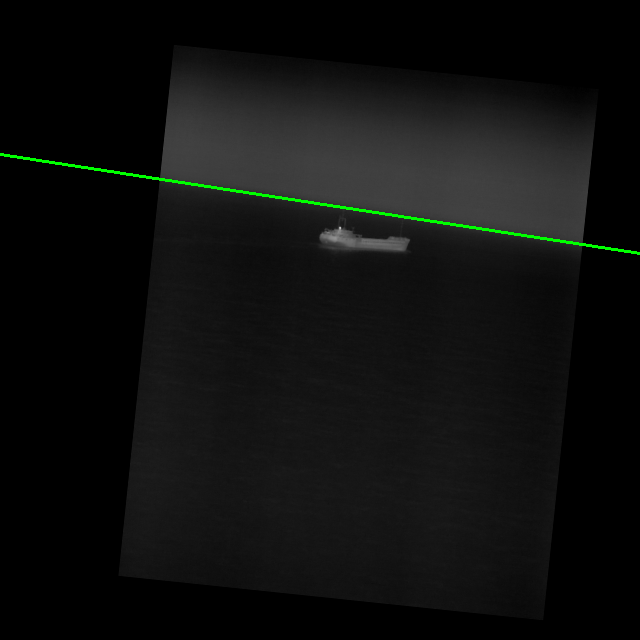

In [4]:
for image, target in train_dataloader:
    break

print(target[0])
I = (image[0].permute(1,2,0) * 255).numpy().astype(np.uint8)
I = draw_horizon(I, pitch_theta=np.array(target[0]), diameter=2)
I = Image.fromarray(I)
I

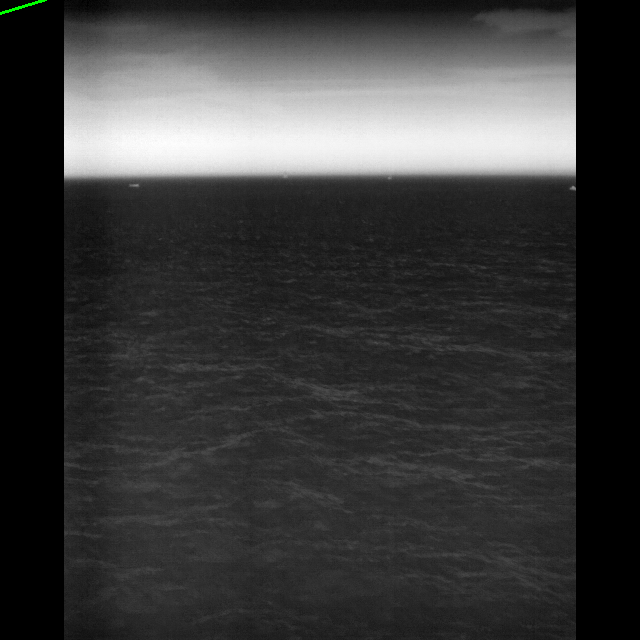

In [5]:
for image, target in val_dataloader:
    break

x_pitch, x_theta = model(image.to(model.device))
pitch, theta = postprocess_x_pitch_theta(x_pitch, x_theta)
pitch, theta = pitch.detach().cpu(), theta.detach().cpu()

I = (image[0].permute(1,2,0) * 255).numpy().astype(np.uint8)
I = draw_horizon(I, pitch_theta=(pitch[0][0], theta[0][0]), diameter=2)
I = Image.fromarray(I)
I

In [6]:
from copy import deepcopy
from datetime import datetime
from tqdm import tqdm
from utils.general import TQDM_BAR_FORMAT

import torch
from torch.cuda import amp
from torch.optim.lr_scheduler import LambdaLR
from utils.torch_utils import smart_optimizer, ModelEMA

epochs = 300
dropout = 0.25

for m in model.modules():
    if isinstance(m, torch.nn.Dropout) and dropout is not None:
        m.p = dropout  # set dropout

for p in model.parameters():
        p.requires_grad = True

optimizer = smart_optimizer(model, name="Adam", lr=0.001, momentum=0.9, decay=0.0001)

lrf = 0.001  # final lr (fraction of lr0)
# lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - lrf) + lrf  # cosine
lf = lambda x: (1 - x / epochs) * (1 - lrf) + lrf  # linear
scheduler = LambdaLR(optimizer, lr_lambda=lf)

loss_pitch = torch.nn.CrossEntropyLoss(label_smoothing=0.0)
loss_theta = torch.nn.CrossEntropyLoss(label_smoothing=0.0)

cuda = model.device != 'cpu'
scaler = amp.GradScaler(enabled=cuda)

ema = ModelEMA(model)
best_loss = 1e10

model.info()

optimizer: Adam(lr=0.001) with parameter groups 33 weight(decay=0.0), 35 weight(decay=0.0001), 35 bias
Model summary: 126 layers, 2823240 parameters, 2823240 gradients, 4.3 GFLOPs


In [7]:
for epoch in range(epochs):
    t_loss, t_ploss, t_tloss = 0.0, 0.0, 0.0
    v_loss, v_ploss, v_tloss = 0.0, 0.0, 0.0
    
    model.train()
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), bar_format=TQDM_BAR_FORMAT)
    for i, data in pbar:
        images, targets = data
        images, targets = images.to(model.device), targets.to(model.device)

        # forward
        x_pitch, x_theta = model(images)

        # process targets
        pitch, theta = targets[...,0], targets[...,1]
        pitch = (pitch * model.nc_pitch).long().clamp(0, model.nc_pitch - 1)
        theta = (theta * model.nc_theta).long().clamp(0, model.nc_theta - 1)

        # backward
        _loss_pitch = loss_pitch(x_pitch, pitch)
        _loss_theta = loss_theta(x_theta, theta)
        loss = _loss_pitch + _loss_theta
        scaler.scale(loss).backward()

        # Optimize
        scaler.unscale_(optimizer)  # unscale gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # clip gradients
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        if ema:
            ema.update(model)

        t_loss = (t_loss * i + loss.item()) / (i + 1)  # update mean losses
        t_ploss = (t_ploss * i + _loss_pitch.item()) / (i + 1)
        t_tloss = (t_tloss * i + _loss_theta.item()) / (i + 1)
        mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
        losses_str = f"{t_loss:>12.3g}{t_ploss:>12.3g}{t_tloss:>12.3g}"
        pbar.desc = f"{'train':>6}{f'{epoch + 1}/{epochs}':>10}{mem:>10}{losses_str}" + ' ' * 10

    scheduler.step()

    model.eval()
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader), bar_format=TQDM_BAR_FORMAT)
    for i, data in pbar:
        images, targets = data
        images, targets = images.to(model.device), targets.to(model.device)

        with torch.no_grad():
            # forward
            x_pitch, x_theta = ema.ema(images)

            # process targets
            pitch, theta = targets[...,0], targets[...,1]
            pitch = (pitch * model.nc_pitch).long().clamp(0, ema.ema.nc_pitch - 1)
            theta = (theta * model.nc_theta).long().clamp(0, ema.ema.nc_theta - 1)

            # store losses
            _loss_pitch = loss_pitch(x_pitch, pitch)
            _loss_theta = loss_theta(x_theta, theta)
            loss = _loss_pitch + _loss_theta

            v_loss = (v_loss * i + loss.item()) / (i + 1)  # update mean losses
            v_ploss = (v_ploss * i + _loss_pitch.item()) / (i + 1)
            v_tloss = (v_tloss * i + _loss_theta.item()) / (i + 1)
        mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
        losses_str = f"{v_loss:>12.3g}{v_ploss:>12.3g}{v_tloss:>12.3g}"
        pbar.desc = f"{'val':>6}{f'{epoch + 1}/{epochs}':>10}{mem:>10}{losses_str}" + ' ' * 10

    if v_loss < best_loss:
        best_loss = v_loss
        ckpt = {
            'epoch': epoch,
            'model': deepcopy(ema.ema),  # deepcopy(de_parallel(model)).half(),
            'ema': None,  # deepcopy(ema.ema).half(),
            'updates': ema.updates,
            'optimizer': None,  # optimizer.state_dict(),
            'losses': dict(pitch=v_ploss, theta=v_tloss, total=v_loss),
            'date': datetime.now().isoformat()}
        torch.save(ckpt, f'best.pt')
        del ckpt

    # Save latest checkpoint
    ckpt = {
        'epoch': epoch,
        'model': deepcopy(ema.ema),  # deepcopy(de_parallel(model)).half(),
        'ema': None,  # deepcopy(ema.ema).half(),
        'updates': ema.updates,
        'optimizer': None,  # optimizer.state_dict(),
        'losses': dict(pitch=v_ploss, theta=v_tloss, total=v_loss),
        'date': datetime.now().isoformat()}
    torch.save(ckpt, f'last.pt')
    del ckpt

 train     1/300     8.25G        8.44        4.78        3.66          : 100%|██████████| 242/242 02:49
   val     1/300     8.25G        6.62        3.89        2.73          : 100%|██████████| 79/79 01:40


RuntimeError: Parent directory /runs does not exist.